In [106]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [107]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [108]:
@njit()
# @jit(nopython=True)
def main_function():
    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    # step_ind.append(0.05)
    # step_vol.append(0.05)
    # w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    step_ind[t] = 1
    step_vol[t] = 1
    w[t] += max_weight / 2
    P[t] = generate_agents()  # Случано сгенерированное текущее поколение

    # P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    # p_qbest_list.append(p_qbest)
    p_qbest_list[t] = p_qbest

    # f_t = list()
    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t
    # F = [numpy.array(f_t)]

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        # step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        # step_vol.append(step_vol[0] * exp(-y * t / iter_max))
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        # P.append(numpy.copy(P[t - 1]))
        # w.append(numpy.copy(w[t - 1]))
        # F.append(numpy.zeros(number_of_agents))
        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        # p_qbest_list.append(p_qbest)
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [109]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [110]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [111]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [112]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [113]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.01333855 -0.95933581]
The function value of pqbest:		1.280233083177201
Algorithm running time:			4.738028049468994 s


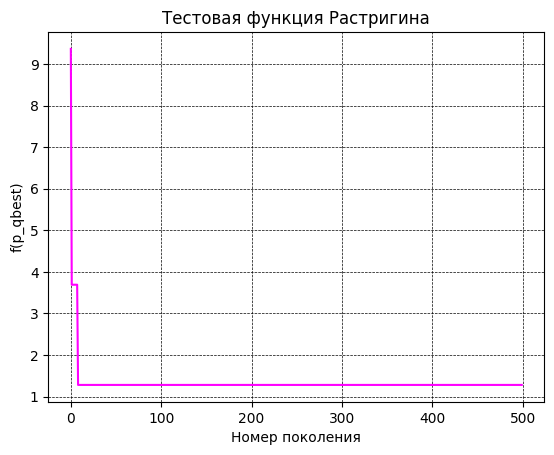

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.02274197 -0.07757622]
The function value of pqbest:		1.2730378263936473
Algorithm running time:			0.032001495361328125 s


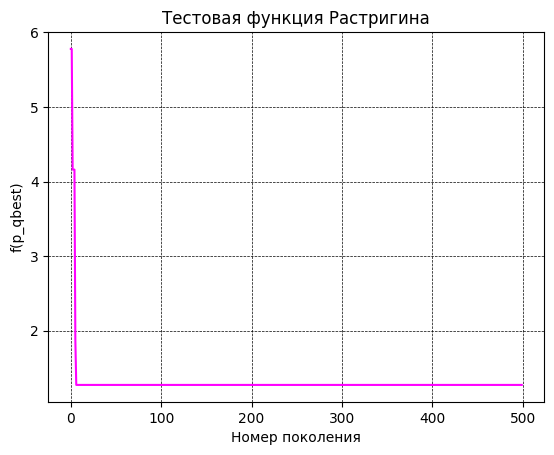

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.00035488 0.9955042 ]
The function value of pqbest:		1.9957528304335455
Algorithm running time:			0.03201889991760254 s


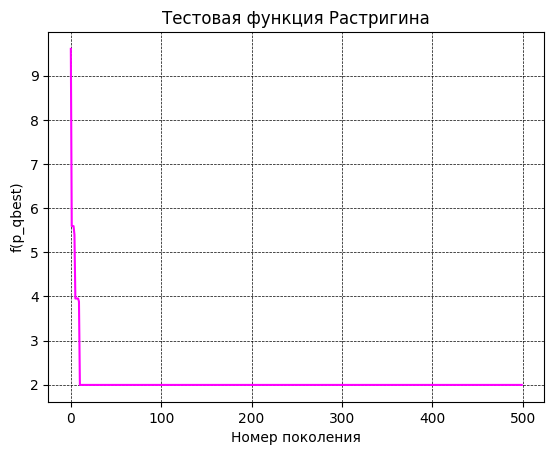

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.06209778 -0.04031651]
The function value of pqbest:		1.0761776855683678
Algorithm running time:			0.048004150390625 s


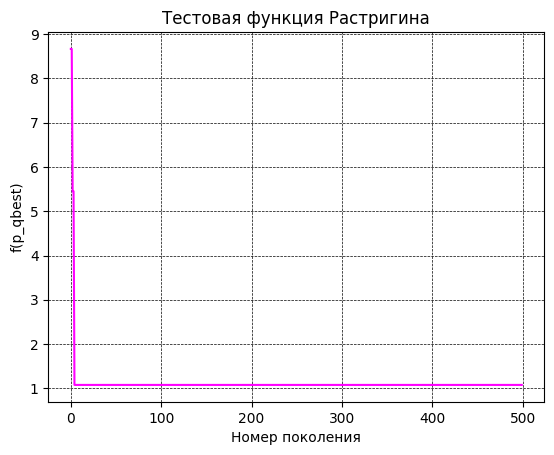

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-1.05632324  0.03493173]
The function value of pqbest:		1.9766170295676133
Algorithm running time:			0.03200364112854004 s


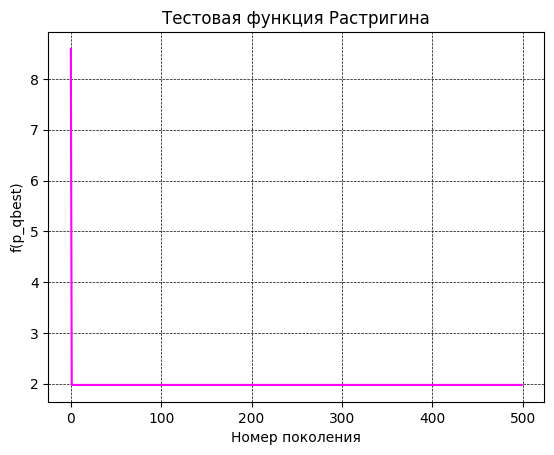

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.93368268  0.92950253]
The function value of pqbest:		3.5564599453077577
Algorithm running time:			0.032004356384277344 s


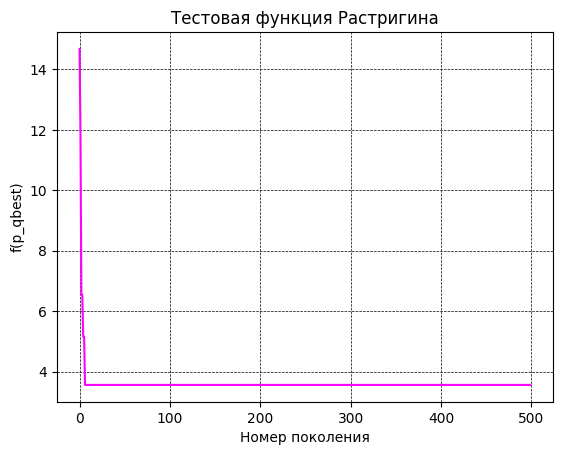

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.05276128 -0.08706438]
The function value of pqbest:		2.014169907353221
Algorithm running time:			0.03198552131652832 s


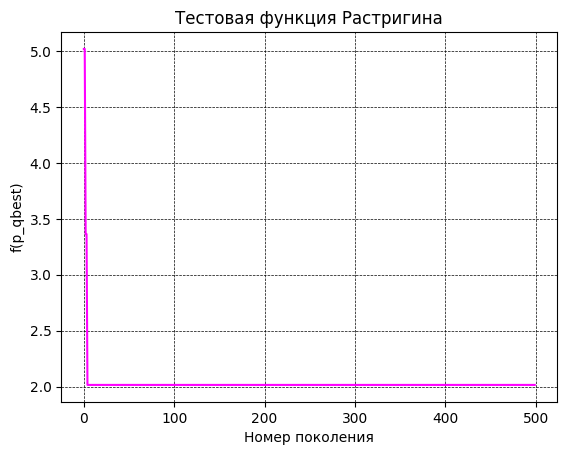

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[1.07582251 0.97186765]
The function value of pqbest:		3.3712519745269276
Algorithm running time:			0.03337430953979492 s


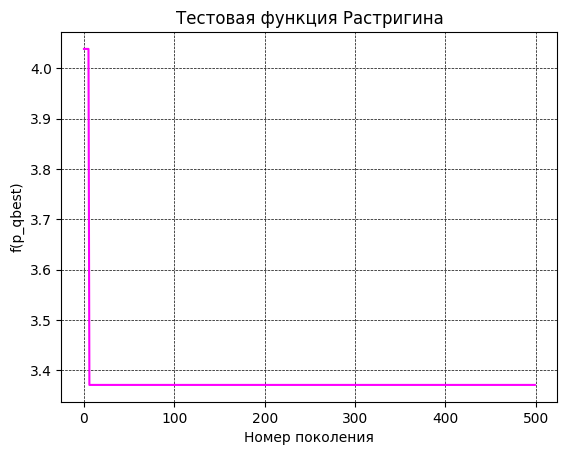

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.01988142 1.07019092]
The function value of pqbest:		3.2202320826012
Algorithm running time:			0.0319981575012207 s


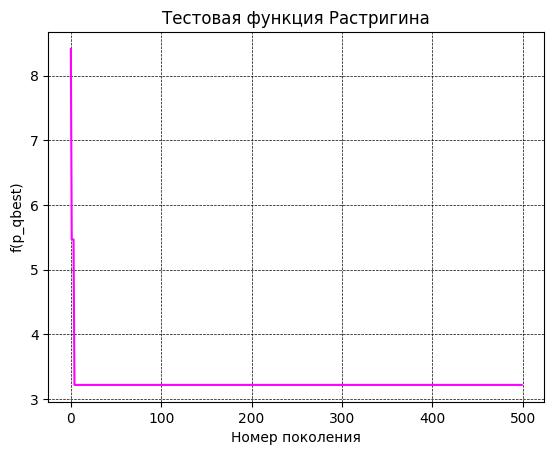

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.0380365  -0.95607051]
The function value of pqbest:		1.5782578343843738
Algorithm running time:			0.056021690368652344 s


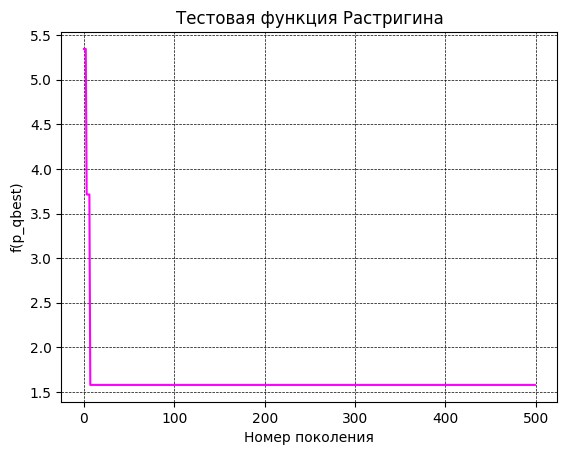

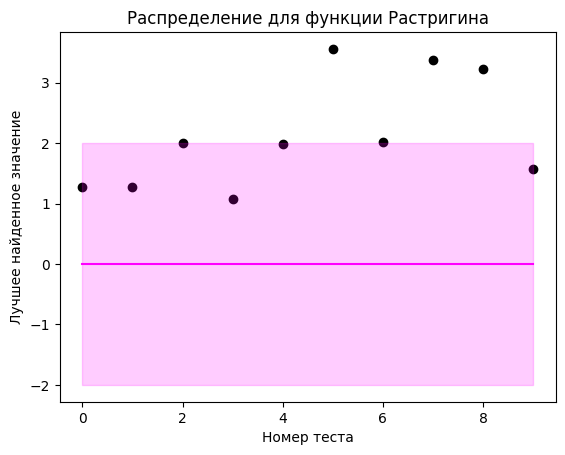

In [114]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [115]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [116]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5, 5, n_args_count)
    # return result
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.0463174  -0.94382007]
The function value of pqbest:		2.6392046590631892
Algorithm running time:			0.032016754150390625 s


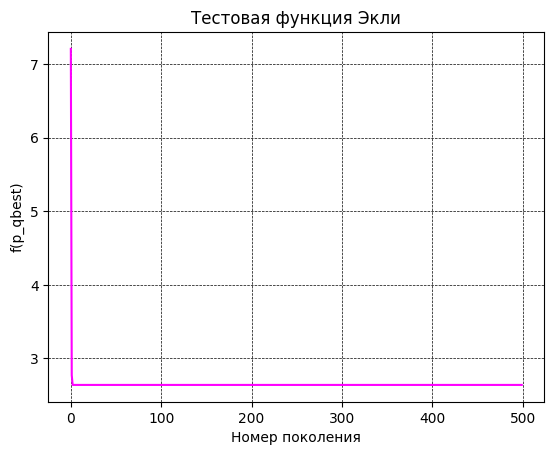

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.98030161 0.05846344]
The function value of pqbest:		2.692597103760189
Algorithm running time:			0.03198742866516113 s


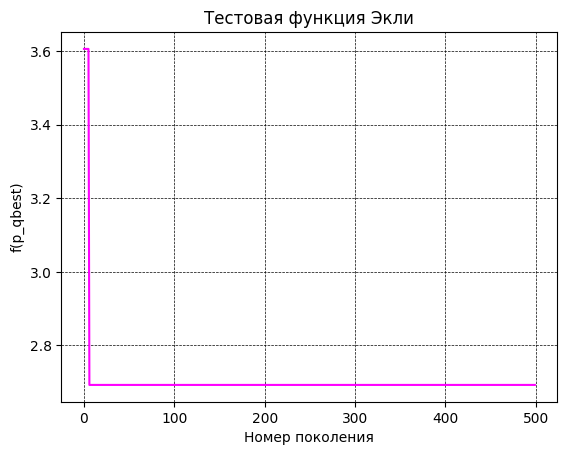

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.10449602 0.02532954]
The function value of pqbest:		0.5856345477649612
Algorithm running time:			0.024016141891479492 s


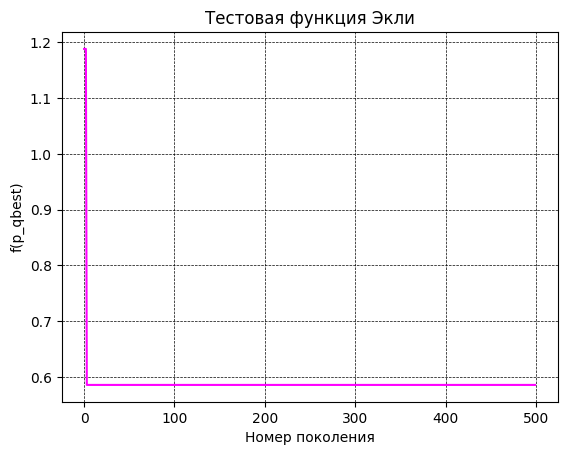

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.99839972 -0.90480967]
The function value of pqbest:		3.6959764704480804
Algorithm running time:			0.03201889991760254 s


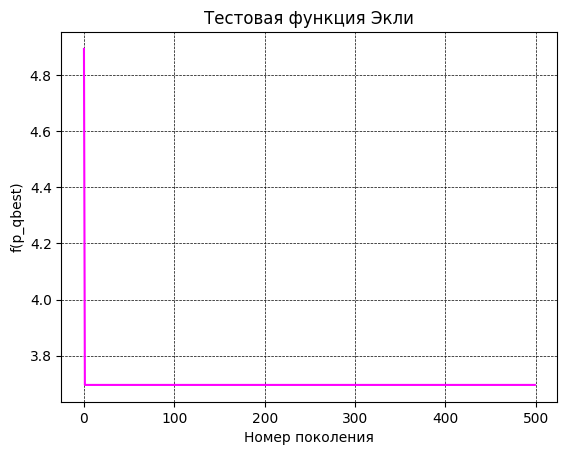

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.14853535  0.98232855]
The function value of pqbest:		3.126446155601055
Algorithm running time:			0.03198957443237305 s


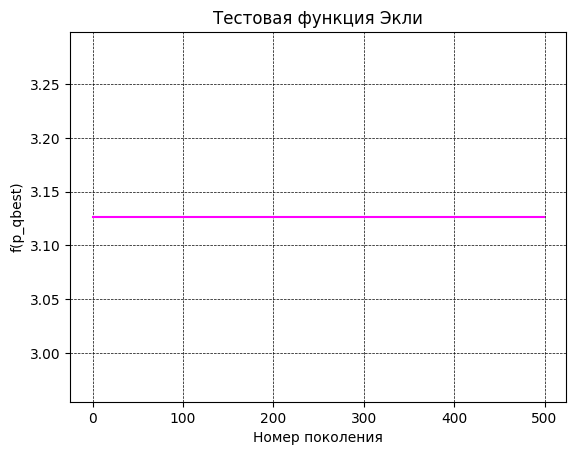

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 1.02817632 -0.01512373]
The function value of pqbest:		2.7340882312061936
Algorithm running time:			0.024461030960083008 s


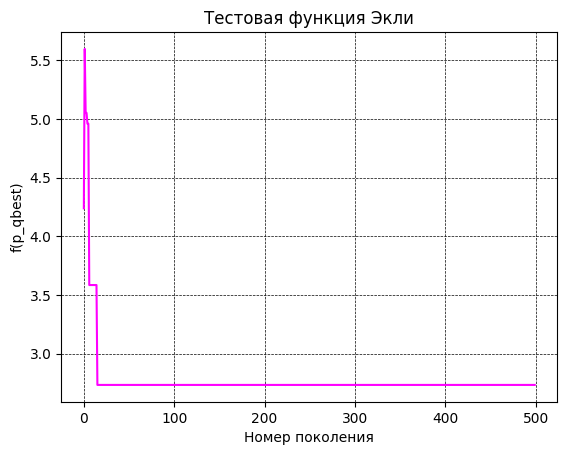

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[1.98085828 0.9783501 ]
The function value of pqbest:		5.3891058137829475
Algorithm running time:			0.04799032211303711 s


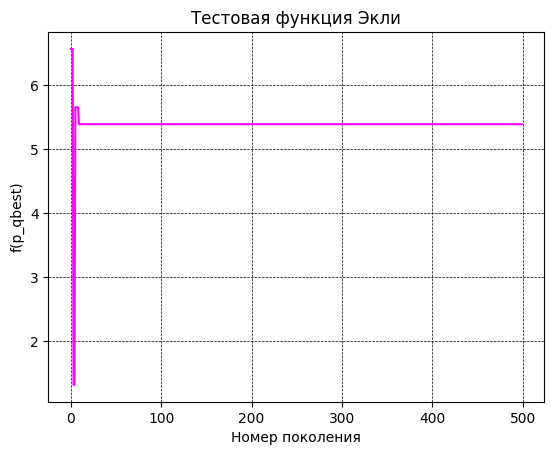

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.12006771 1.00469111]
The function value of pqbest:		3.0119406400111153
Algorithm running time:			0.03199267387390137 s


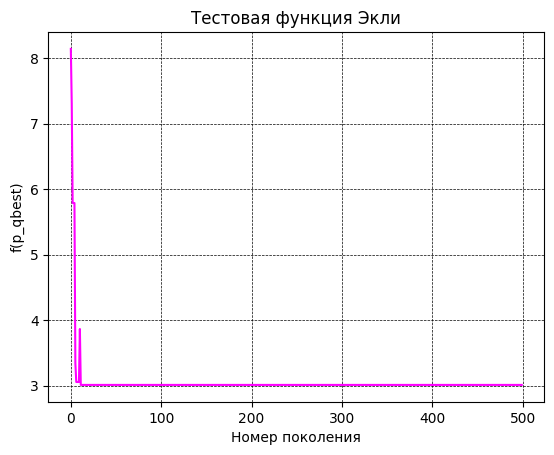

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.02939188 0.95600813]
The function value of pqbest:		3.6773680606560717
Algorithm running time:			0.024003028869628906 s


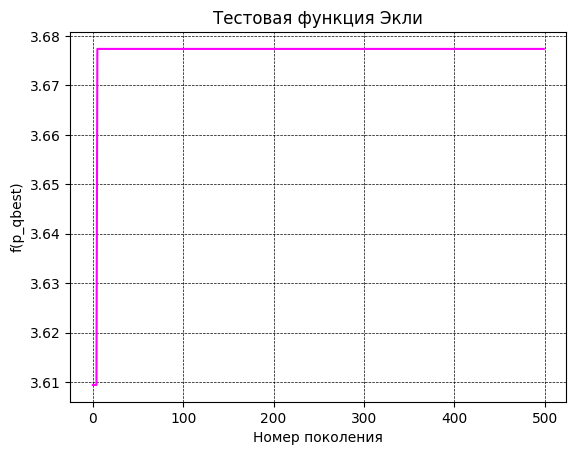

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.1103514   0.03487812]
The function value of pqbest:		0.6498474271560788
Algorithm running time:			0.02400660514831543 s


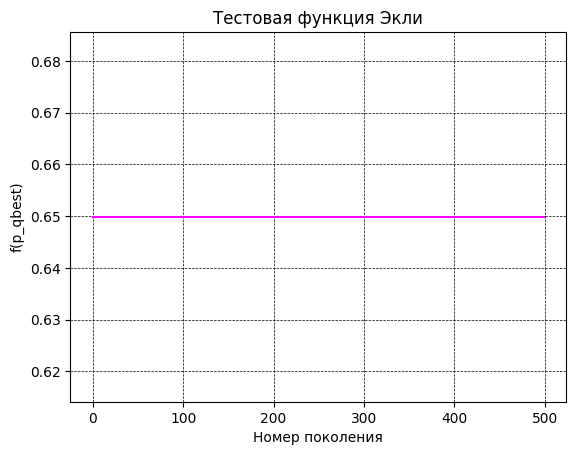

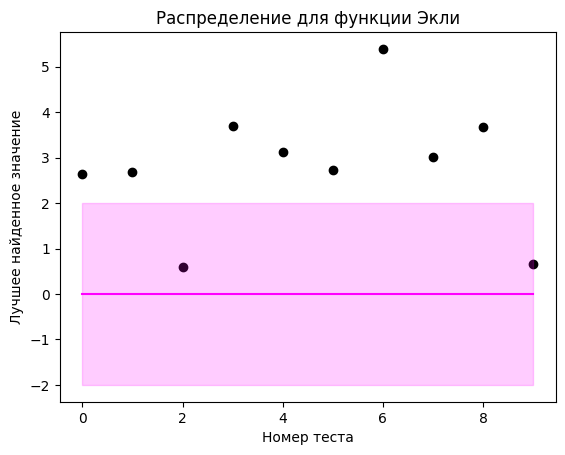

In [117]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [118]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [119]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-10, 10, n_args_count)
    # return result
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.13526648 0.00358654]
The function value of pqbest:		0.01830988276808533
Algorithm running time:			0.024016380310058594 s


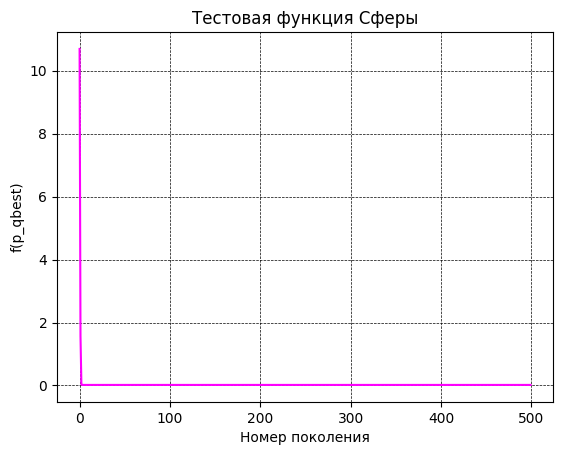

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.96375673 -1.12363076]
The function value of pqbest:		2.191373116391207
Algorithm running time:			0.01800251007080078 s


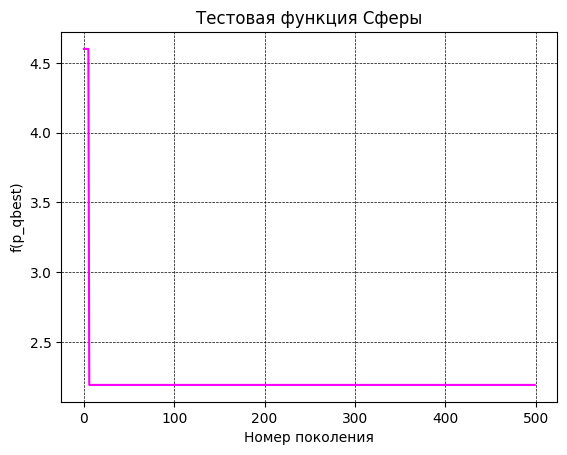

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.04657015 1.06192367]
The function value of pqbest:		2.222990958698177
Algorithm running time:			0.015994548797607422 s


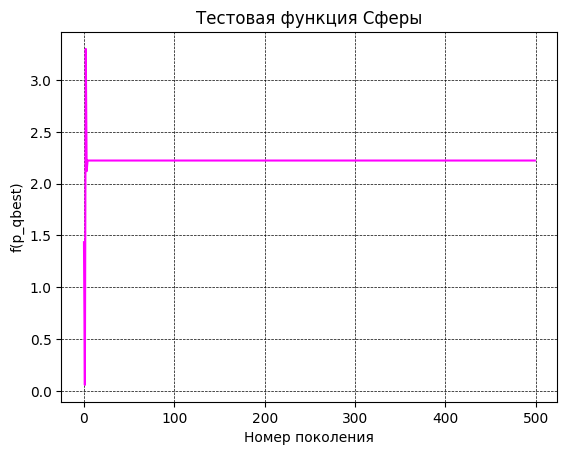

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.02854712 -0.92449805]
The function value of pqbest:		0.8555115852148197
Algorithm running time:			0.024002790451049805 s


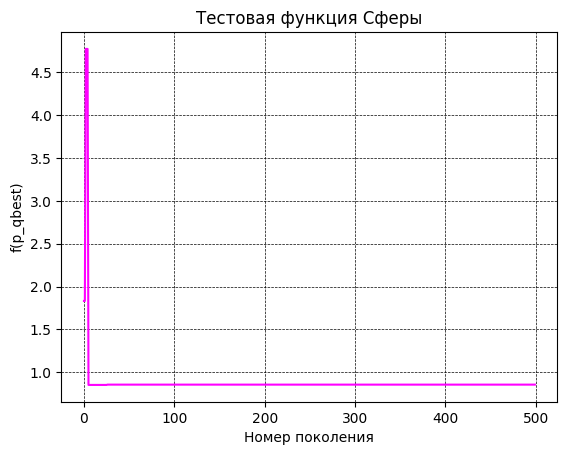

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.92997354 0.10958553]
The function value of pqbest:		0.8768597673220051
Algorithm running time:			0.0240018367767334 s


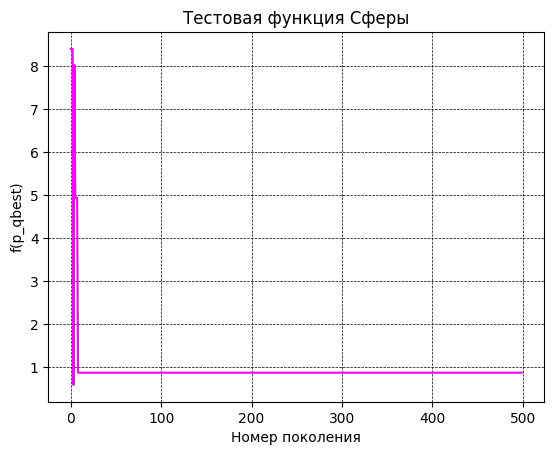

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.05504418 0.04588577]
The function value of pqbest:		0.005135365721782605
Algorithm running time:			0.016013145446777344 s


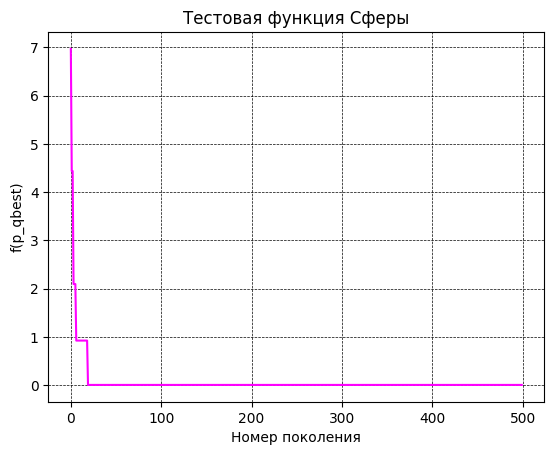

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.93037044 -0.0491212 ]
The function value of pqbest:		0.8680020559552473
Algorithm running time:			0.01600813865661621 s


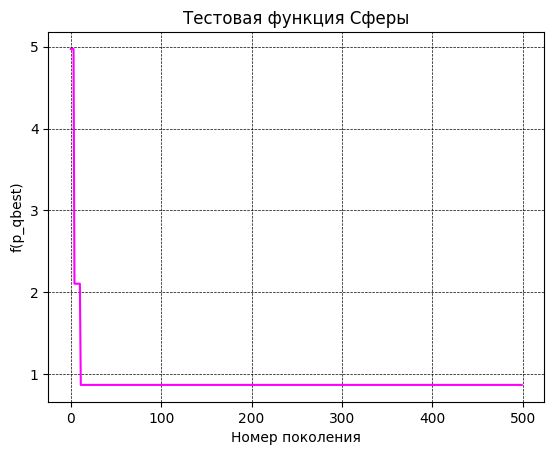

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-1.04542301  0.05260339]
The function value of pqbest:		1.0956763809250634
Algorithm running time:			0.016008377075195312 s


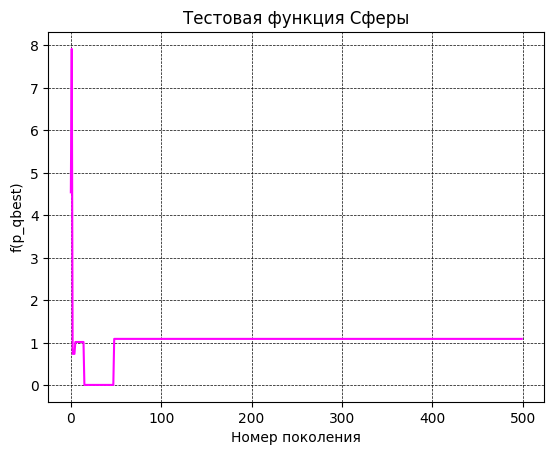

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.96468008 -1.02070276]
The function value of pqbest:		1.9724417800174976
Algorithm running time:			0.024023056030273438 s


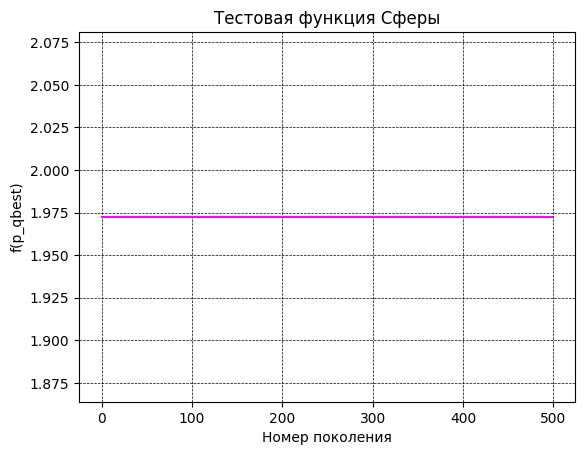

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-1.0662008  -0.06043759]
The function value of pqbest:		1.140436838131988
Algorithm running time:			0.024002552032470703 s


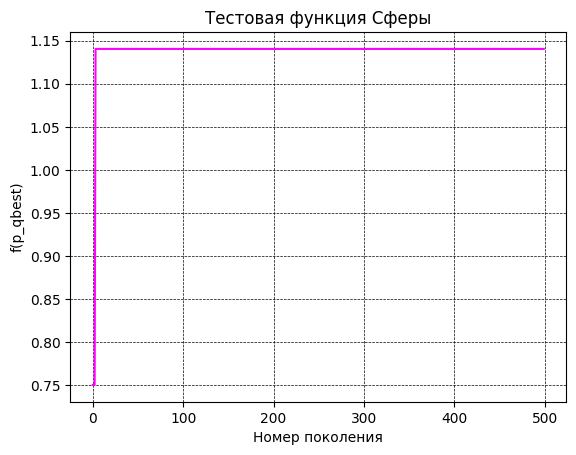

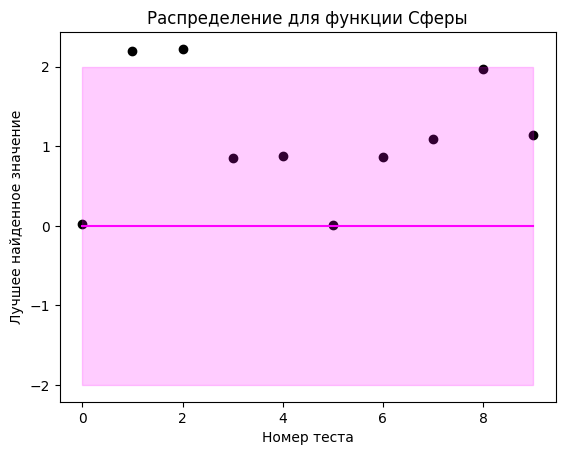

In [120]:
start_test("Сферы")
